In [1]:
from fastai.vision.all import *
from os.path import isfile
import torch
import pathlib

import pandas as pd

In [2]:
def get_street_path(row):
	fov = 120
	heading = [0,120,240]
	path = [f"Images/{row['name']}/{row['pano_id']}___{fov}___{head}___{row['name']}.jpg" for head in heading]
	return [pathlib.Path(p) for p in path]
	
def get_street_images(df):
	lsts = df.apply(get_street_path, axis=1).tolist()
	#return flattened list
	return [p for lst in lsts for p in lst]
	
def get_city(pathlike):
	return pathlike.name[:-4].split('___')[3]

In [6]:
def remove_invalid(df):
    #maybe interesting to check these out since we used lat lng from metadata api but failed to fetch from image api
	initial_len = len(df)
	result = []
	for tup in df.iterrows():
		paths = get_street_path(tup[1])
		for p in paths:
			if not isfile(p):
				break
		else:
			result.append(tup[1])
	print(f'removed {initial_len-len(result)} invalid rows')
	return pd.DataFrame(result)
	
def get_all_metadata():
	if not isfile("metadata/allcities.csv"):
		cities = [('New York', 'NY'), ('Los Angeles', 'CA'), ('Chicago', 'IL'), ('Houston', 'TX'), ('Phoenix', 'AZ'), ('Philadelphia', 'PA'), ('Jacksonville', 'FL'), ('Columbus', 'OH'), ('Charlotte', 'NC'), ('Indianapolis', 'IN')]
		result = []
		for city in cities:
			df = pd.read_csv(f"metadata/{city[0]}.csv")
			df['name'] = city[0]
			#We limited data generation to first 2000 points. Can modify this if we gather more data later
			df = df.iloc[0:2000]
			result.append(df)
		df = pd.concat(result)
		df = remove_invalid(df)
		df.to_csv('metadata/allcities.csv', index=False)
	else:
		df = pd.read_csv('metadata/allcities.csv')
	return df

In [4]:
df = get_all_metadata()

,copyright,date,location,pano_id,status,name
0,© Google,2021-11,"{'lat': 40.65955452384981, 'lng': -73.76835535320036}",vbDI5iRskKoMXALDb5hS_A,OK,New York
1,© Google,2019-10,"{'lat': 40.50382435850913, 'lng': -74.23818095941284}",Uh_7uJ1Q9gX2TUmFzbktcQ,OK,New York
2,© Google,2022-09,"{'lat': 40.56078423411252, 'lng': -74.1195630047877}",eQ4Y2a65EF43GQKlIIoo1A,OK,New York
3,© Google,2022-09,"{'lat': 40.74408454631125, 'lng': -73.86397192186925}",rXE1gixoMRrP0lVbSRdp5Q,OK,New York
4,© Google,2022-06,"{'lat': 40.77170818054856, 'lng': -73.79223616507709}",rI3gcoX_3U17k0OADfoO9Q,OK,New York


In [31]:
#Do we want to add a item_tfms=Resize({int},ResizeMethod.Squish) below?
streetview_block = DataBlock(
	blocks=(ImageBlock, CategoryBlock),
	get_items=get_street_images,
	splitter=RandomSplitter(valid_pct=0.2, seed=42),
	get_y=get_city,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(mult=1)
	)

In [32]:
dls = streetview_block.dataloaders(df)

From a human point of view this task is looking difficult from the batch below

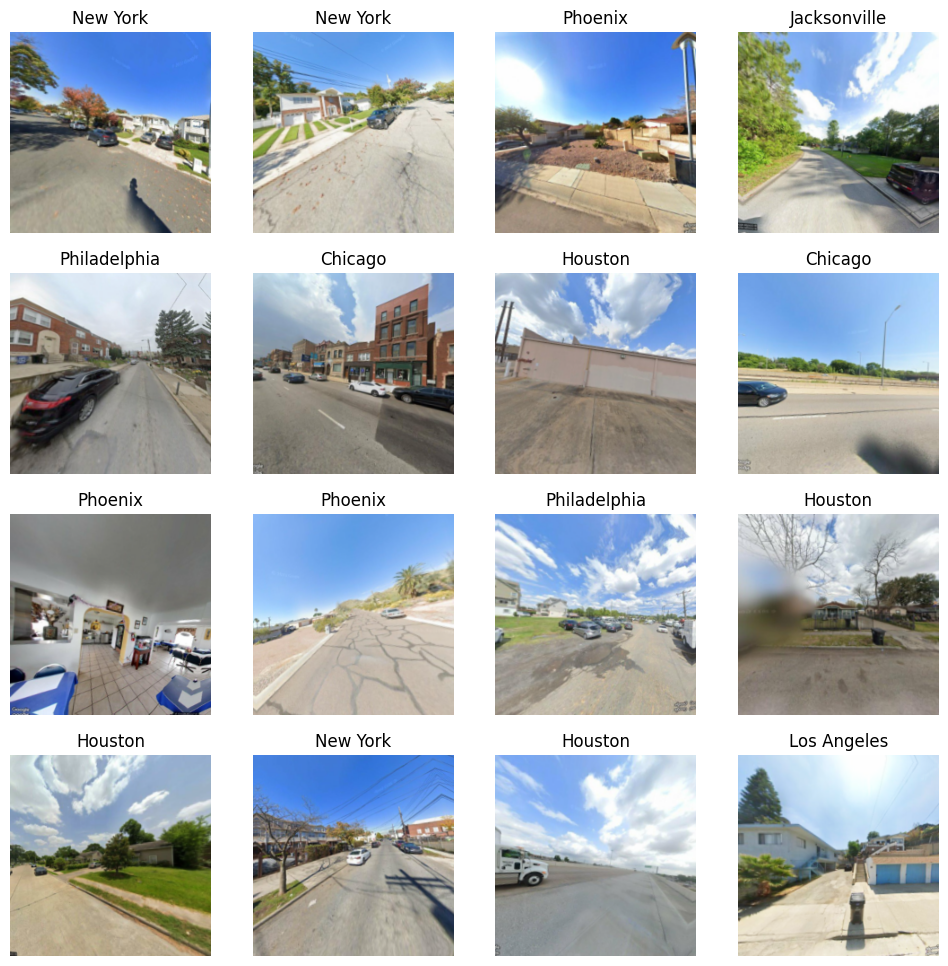

In [33]:
dls.show_batch(max_n=16, nrows=4)

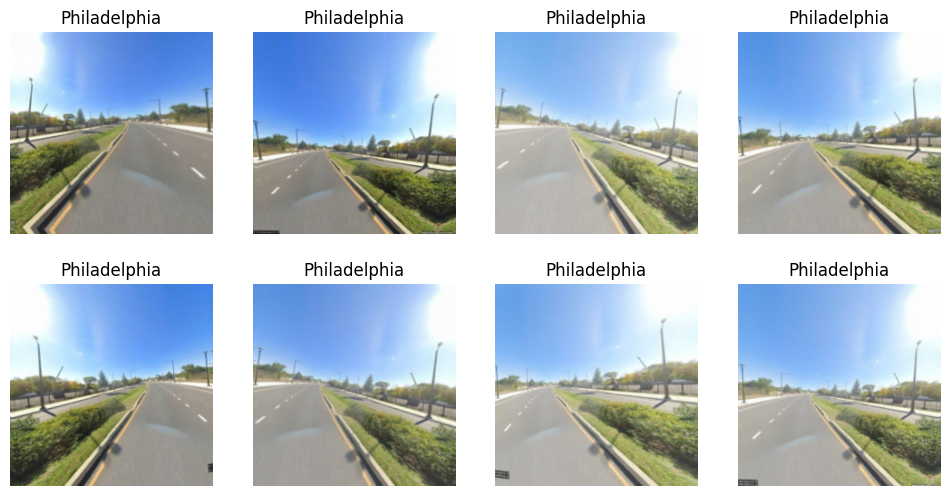

In [34]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)